In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
data_dir = r"C:\Users\ual-laptop\Documents\stat nlp"
print(os.listdir(data_dir))  # This will list files in your specified directory

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 200)

['IMDB Dataset.csv', 'README.md', 'SentimentAnalysis.ipynb']


### 1. Loading the Dataset

Loading the dataset using the simple pandas.read_csv



In [2]:
file_path = r"C:\Users\ual-laptop\Documents\stat nlp\IMDB Dataset.csv"
df = pd.read_csv(file_path)
df.head(10)


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 o...",positive
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in me.I grew up on black and white TV and Seahunt with Gun...,positive
7,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny ...",negative
8,Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful i...,negative
9,"If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",positive


## 2. Exploratory Data Analysis

EDA helps understand the data's structure, patterns, and quality before modeling. It identifies issues like missing values and reveals insights for better decision-making.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what w...",positive
freq,5,25000


* Number of reviews: 50,000

* Unique reviews: 49,582 (showing a lot of repeating reviews)

* Most frequent review: "Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what w..."

* Frequency of most frequent review: Appears 5 times

* Sentiment labels: 2 unique sentiment categories: positive and negative

* Most frequent sentiment: positive

* Frequency of positive sentiment: 25,000 occurrences


Sentiment Count

In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

We can see that the dataset is balanced.

**Checking the distribution of the sentiment classes**

Spliting the training dataset

In [6]:
# Splitting the data into training and testing sets
train_res=df.review[:40000]
train_sents=df.sentiment[:40000]
#test dataset
test_reviews=df.review[40000:]
test_sentiments=df.sentiment[40000:]
print(train_res.shape,train_sents.shape)
print(test_reviews.shape,test_sentiments.shape)



(40000,) (40000,)
(10000,) (10000,)


Text normalization

In [7]:
# Initialize tokenizer for breaking text into words
word_splitter = ToktokTokenizer()

# Load common English stopwords to filter out unimportant words
english_stopwords = nltk.corpus.stopwords.words('english')


Removing html strips and noise text

In [8]:
# Clean HTML tags from the text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)


Removing special characters

In [11]:
# Function to clean out punctuation and symbols (optionally digits too)
def strip_special_symbols(text_input, remove_digits=True):
    pattern = r'[^a-zA-Z0-9\s]'
    text_input = re.sub(pattern, '', text_input )
    return text_input

# Apply the cleaner to each review
df['review'] = df['review'].apply(strip_special_symbols)


Text stemming

In [10]:
# Reduce words to their root forms using stemming
def stem_words(text_data):
    stemmer = nltk.PorterStemmer()
    text_data = ' '.join([stemmer.stem(word) for word in text_data.split()])
    return text_data

# Apply stemming to each review in the dataset
df['review'] = df['review'].apply(stem_words)


Removing stopwords

In [12]:
# Load English stopwords into a set for faster lookup
ignore = set(stopwords.words('english'))
print(ignore)

# Function to remove common stopwords from text
def filter_stopwords(text_input, lowercase=False):
    tokens = word_splitter.tokenize(text_input)
    tokens = [token.strip() for token in tokens]
    
    if lowercase:
        cleaned_tokens = [word for word in tokens if word not in english_stopwords]
    else:
        cleaned_tokens = [word for word in tokens if word.lower() not in english_stopwords]
    
    return ' '.join(cleaned_tokens)

# Clean up reviews by filtering out stopwords
df['review'] = df['review'].apply(filter_stopwords)


{'itself', 'just', 'needn', 'they', 'below', 'before', "couldn't", 'each', 'our', 'after', 'with', 'yours', 'their', "needn't", "she'd", 'theirs', "i've", "you've", 'herself', 've', "should've", 'her', 'll', 'out', "that'll", 'when', 'why', "it'd", 'will', "won't", "didn't", 'some', 'that', 'do', 'am', 'd', 'for', "he'll", 'down', 'more', "they'll", 'while', 'me', 'is', "we're", 'she', 'most', 'i', 'because', 'such', 'weren', 'its', 'few', 'to', 'any', 'had', 'y', 'ourselves', 'has', 'you', 'was', "we'll", 'shouldn', 'there', 'don', 'once', "wasn't", "i'll", "weren't", 's', 'only', 'not', 'have', 'nor', 'haven', 'his', 'of', 'shan', 'them', 'myself', 'we', 'mustn', 'or', "mustn't", 'here', 'ain', 'until', 'himself', "i'm", "you're", 'it', 'how', 'where', 'themselves', 'ours', 'so', "wouldn't", 'your', 'up', 'an', 'be', 'through', "aren't", 'hasn', 'couldn', 'between', 'then', 'if', 'those', "doesn't", 'my', "he's", "she'll", 'been', 'further', 'in', "he'd", 'who', 'which', "we've", "sh

Normalized train reviews

In [13]:
#normalized train reviews
norm_train=df.review[:40000]
norm_train[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

Normalized test reviews

In [14]:
# Extract the test reviews (from the 40,001st review onward)
norm_test=df.review[40000:]
norm_test[45005]

# Display a specific review from the test set for inspection
#print(cleaned_test_reviews.iloc[45005])

# (Optional) Combine all test reviews into a single string
# full_test_review_text = cleaned_test_reviews.to_string()

# (Optional) Use TextBlob to correct any spelling mistakes in the reviews
# corrected_test_text = TextBlob(full_test_review_text).correct()

# (Optional) Tokenize the corrected text into individual words
# tokenized_test_words = corrected_test_text.words
# print(tokenized_test_words)


'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

Bags of words model

It is used to convert text documents to numerical vectors or bag of words.

In [15]:

# Initialize the CountVectorizer with bigrams and trigrams, allowing all words
vectorizer = CountVectorizer(min_df=1, max_df=1.0, binary=False, ngram_range=(1, 3))

# Apply the vectorizer to the training and testing review data
train_vectorized = vectorizer.fit_transform(norm_train)
test_vectorized = vectorizer.transform(norm_test)

# Display the shape of the resulting document-term matrices
print('Shape of training data BOW:', train_vectorized.shape)
print('Shape of testing data BOW:', test_vectorized.shape)

# Retrieve the feature names (vocabulary)
# vocabulary = vectorizer.get_feature_names_out()


Shape of training data BOW: (40000, 6982844)
Shape of testing data BOW: (10000, 6982844)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to matrix of tfidf features.

In [17]:
# Initialize the TfidfVectorizer with unigrams, bigrams, and trigrams
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True, ngram_range=(1, 3))

# Apply the vectorizer to the training and test data
train_tfidf = tfidf_vectorizer.fit_transform(norm_train)
test_tfidf = tfidf_vectorizer.transform(norm_test)

# Output the shape of the resulting TF-IDF matrices
print('Shape of training data TF-IDF:', train_tfidf.shape)
print('Shape of testing data TF-IDF:', test_tfidf.shape)


Shape of training data TF-IDF: (40000, 6982844)
Shape of testing data TF-IDF: (10000, 6982844)


Labeling the sentiment text

In [18]:
# Initialize the LabelBinarizer for encoding the sentiment labels
label_encoder = LabelBinarizer()

# Transform the sentiment labels into binary format
encoded_sentiment = label_encoder.fit_transform(df['sentiment'])

# Display the shape of the transformed sentiment data
print('Shape of encoded sentiment data:', encoded_sentiment.shape)


Shape of encoded sentiment data: (50000, 1)


Split the sentiment tdata

In [19]:
# Split the encoded sentiment data into training and testing sets
training_sentiments = encoded_sentiment[:40000]
testing_sentiments = encoded_sentiment[40000:]

# Display the training and testing sentiment data
print('Training Sentiment Data:', training_sentiments)
print('Testing Sentiment Data:', testing_sentiments)


Training Sentiment Data: [[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
Testing Sentiment Data: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


**Modelling the dataset**

Let us build logistic regression model for both bag of words and tfidf features

In [20]:
# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

# Train the model using the Bag of Words features
bow_model = log_reg_model.fit(train_vectorized, training_sentiments)
print('Model trained with Bag of Words:', bow_model)

# Train the model using the TF-IDF features
tfidf_model = log_reg_model.fit(train_tfidf, training_sentiments)
print('Model trained with TF-IDF:', tfidf_model)


Model trained with Bag of Words: LogisticRegression(C=1, max_iter=500, random_state=42)
Model trained with TF-IDF: LogisticRegression(C=1, max_iter=500, random_state=42)


Logistic regression model performane on test dataset

In [21]:
# Predict using the model trained with Bag of Words features
bow_predictions = log_reg_model.predict(test_vectorized)
print('Predictions with Bag of Words:', bow_predictions)

# Predict using the model trained with TF-IDF features
tfidf_predictions = log_reg_model.predict(test_tfidf)
print('Predictions with TF-IDF:', tfidf_predictions)


Predictions with Bag of Words: [0 0 0 ... 0 0 0]
Predictions with TF-IDF: [0 0 0 ... 1 0 0]


Accuracy of the model

In [22]:

# Calculate accuracy for the model trained with Bag of Words features
bow_accuracy = accuracy_score(testing_sentiments, bow_predictions)
print("Accuracy for Bag of Words model:", bow_accuracy)

# Calculate accuracy for the model trained with TF-IDF features
tfidf_accuracy = accuracy_score(testing_sentiments, tfidf_predictions)
print("Accuracy for TF-IDF model:", tfidf_accuracy)


Accuracy for Bag of Words model: 0.8394
Accuracy for TF-IDF model: 0.8872


Print the classification report

In [23]:

# Generate the classification report for the Bag of Words model
bow_classification_report = classification_report(testing_sentiments, bow_predictions, target_names=['Positive', 'Negative'])
print('Classification Report for Bag of Words Model:\n', bow_classification_report)

# Generate the classification report for the TF-IDF model
tfidf_classification_report = classification_report(testing_sentiments, tfidf_predictions, target_names=['Positive', 'Negative'])
print('Classification Report for TF-IDF Model:\n', tfidf_classification_report)


Classification Report for Bag of Words Model:
               precision    recall  f1-score   support

    Positive       0.79      0.91      0.85      4993
    Negative       0.90      0.76      0.83      5007

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

Classification Report for TF-IDF Model:
               precision    recall  f1-score   support

    Positive       0.89      0.89      0.89      4993
    Negative       0.89      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Confusion matrix

In [24]:
# Generate the confusion matrix for the Bag of Words model
bow_confusion_matrix = confusion_matrix(testing_sentiments, bow_predictions, labels=[1, 0])
print('Confusion Matrix for Bag of Words Model:\n', bow_confusion_matrix)

# Generate the confusion matrix for the TF-IDF model
tfidf_confusion_matrix = confusion_matrix(testing_sentiments, tfidf_predictions, labels=[1, 0])
print('Confusion Matrix for TF-IDF Model:\n', tfidf_confusion_matrix)


Confusion Matrix for Bag of Words Model:
 [[3829 1178]
 [ 428 4565]]
Confusion Matrix for TF-IDF Model:
 [[4447  560]
 [ 568 4425]]


Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features

In [26]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(train_vectorized,training_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(train_tfidf,training_sentiments)
print(svm_tfidf)


SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


Model performance on test data

In [29]:
# Making predictions with the SVM model trained on Bag of Words features
svm_bow_predict=svm.predict(test_vectorized)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(test_tfidf)
print(svm_tfidf_predict)


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


Accuracy of the model

In [30]:
# Evaluating accuracy for the SVM model trained with Bag of Words features
bow_accuracy_score = accuracy_score(testing_sentiments, svm_bow_predict)
print("Accuracy of SVM model using Bag of Words:", bow_accuracy_score)

# Evaluating accuracy for the SVM model trained with TF-IDF features
tfidf_accuracy_score = accuracy_score(testing_sentiments, svm_tfidf_predict)
print("Accuracy of SVM model using TF-IDF:", tfidf_accuracy_score)


Accuracy of SVM model using Bag of Words: 0.8432
Accuracy of SVM model using TF-IDF: 0.887


Print the classification report

In [32]:
# Generate classification details for SVM using Bag of Words
report_bow_svm = classification_report(testing_sentiments, svm_bow_predict, target_names=['Positive', 'Negative'])
print('SVM - Bag of Words Classification Summary:\n', report_bow_svm)

# Generate classification details for SVM using TF-IDF features
report_tfidf_svm = classification_report(testing_sentiments, svm_tfidf_predict, target_names=['Positive', 'Negative'])
print('SVM - TF-IDF Classification Summary:\n', report_tfidf_svm)


SVM - Bag of Words Classification Summary:
               precision    recall  f1-score   support

    Positive       0.80      0.91      0.85      4993
    Negative       0.90      0.77      0.83      5007

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

SVM - TF-IDF Classification Summary:
               precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      4993
    Negative       0.88      0.90      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Plot the confusion matrix

In [33]:
# Confusion matrix for SVM model using Bag of Words representation
conf_matrix_bow_svm = confusion_matrix(testing_sentiments, svm_bow_predict, labels=[1, 0])
print('SVM Confusion Matrix (Bag of Words):\n', conf_matrix_bow_svm)

# Confusion matrix for SVM model using TF-IDF representation
conf_matrix_tfidf_svm = confusion_matrix(testing_sentiments, svm_tfidf_predict, labels=[1, 0])
print('SVM Confusion Matrix (TF-IDF):\n', conf_matrix_tfidf_svm)


SVM Confusion Matrix (Bag of Words):
 [[3879 1128]
 [ 440 4553]]
SVM Confusion Matrix (TF-IDF):
 [[4495  512]
 [ 618 4375]]


Multinomial Naive Bayes for bag of words and tfidf features

In [34]:
# Create an instance of the Multinomial Naive Bayes classifier
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(train_vectorized,training_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(train_tfidf,training_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


Model performance on test data

In [35]:
# Generate sentiment predictions using the SVM model trained on Bag of Words data
mnb_bow_predict=mnb.predict(test_vectorized)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(test_tfidf)
print(mnb_tfidf_predict)



[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


Accuracy of the model

In [36]:
# Evaluate prediction accuracy of SVM model using Bag of Words representation
mnb_bow_score=accuracy_score(testing_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(testing_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)



mnb_bow_score : 0.8787
mnb_tfidf_score : 0.8892


Print the classification report

In [37]:
# Detailed metrics for Naive Bayes using Bag of Words features
mnb_bow_report=classification_report(testing_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(testing_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)


              precision    recall  f1-score   support

    Positive       0.85      0.92      0.88      4993
    Negative       0.91      0.84      0.87      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

    Positive       0.88      0.90      0.89      4993
    Negative       0.90      0.88      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Plot the confusion matrix

In [38]:
# Confusion matrix for SVM model using Bag of Words
cm_bow=confusion_matrix(testing_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(testing_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4218  789]
 [ 424 4569]]
[[4391  616]
 [ 492 4501]]


Let us see positive and negative words by using WordCloud.

Word cloud for positive review words

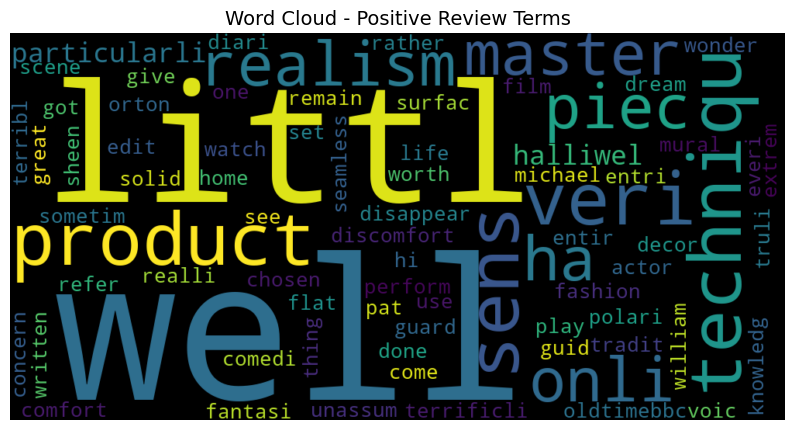

In [39]:
# Visualizing most common words in positive reviews using WordCloud
plt.figure(figsize=(10, 10))
positive_review_text = norm_train[1]  # assuming index 1 holds positive review text
wordcloud_gen = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_wordcloud = wordcloud_gen.generate(positive_review_text)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes for cleaner display
plt.title("Word Cloud - Positive Review Terms", fontsize=14)
plt.show()


Word cloud for negative review words

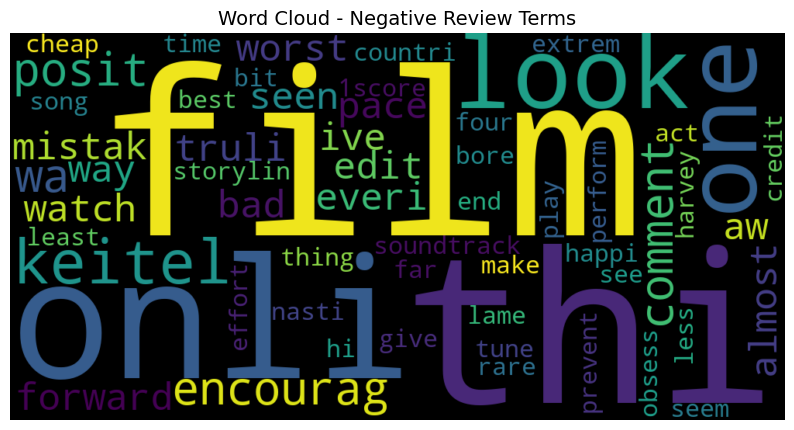

In [40]:
# Create a word cloud to visualize common words in a negative review
plt.figure(figsize=(10, 10))
negative_review_content = norm_train[8]  # assumes index 8 is a negative review
cloud_generator = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
neg_wordcloud = cloud_generator.generate(negative_review_content)

plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes for visual clarity
plt.title("Word Cloud - Negative Review Terms", fontsize=14)
plt.show()


**Conclusion:**

* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector machines.
* Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.